# Sarcasm Detection

The purpose of the project is to detect sarcasm in the news headline sentences and analyze the detection model performance (baseline, LSTM, Convolutional, ...etc).

The data used in the project is the News Headlines Dataset for Sarcasm Detection on Kaggle website: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection 

<img src ='426617534.jpg'>

In [1]:
#Importing libraries
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense, Bidirectional, Conv1D, Dropout, GRU, LSTM, MaxPooling1D
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

print(tf.__version__)

2.0.0-beta1


### 1. Import Sarcasm Data and Preprocessing

In [2]:
# input data and label the feature 
sarcasm = []
for line in open("Sarcasm_Headlines_Dataset_v2.json", "r"):
  sarcasm.append(json.loads(line))

sentences =[]
labels = []
urls = []

for item in sarcasm: 
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])
    
print(sentences[:6])
print(labels[:6])
print(urls[:6])
len(labels)

## Note another way to load is pd.read_json('') which, i think, is more convenient 
##

['thirtysomething scientists unveil doomsday clock of hair loss', 'dem rep. totally nails why congress is falling short on gender, racial equality', 'eat your veggies: 9 deliciously different recipes', 'inclement weather prevents liar from getting to work', "mother comes pretty close to using word 'streaming' correctly", 'my white inheritance']
[1, 0, 0, 1, 1, 0]
['https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205', 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207', 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html', 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031', 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546', 'https://www.huffingtonpost.com/entry/my-white-inheritance_us_59230747e4b07617ae4cbe1a']


28619

In [3]:
# Input the hyperparameter so we can adjust later
vocab_size  = 100000
embedding_dim = 64
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = 'Unknown'

In [4]:
# Split Data into train and test set
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size = 0.2, random_state = 1)

# Preprocessing data 
# take in data and encode
tokenizer = Tokenizer(num_words = vocab_size,oov_token = oov_tok)
tokenizer.fit_on_texts(train_sentences)
# return dict comprise of key values pair: word and its indices
word_index = tokenizer.word_index

# return a sequence of indices representing wordssentences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# pad sequences to same length
train_padded = pad_sequences(train_sequences, maxlen = max_length, 
                               padding = padding_type, truncating = trunc_type)
test_padded = pad_sequences(test_sequences, maxlen = max_length,
                              padding = padding_type, truncating = trunc_type)

print(len(train_sentences))
print(len(test_sentences))
print(train_sentences[0])
print(train_sequences[0])
print(train_padded)
print(test_sentences[0])
print(test_sequences[0])
print(test_padded[0])

22895
5724
national archives clearly stored constitution in three-ring binder
[251, 1377, 738, 9857, 2436, 5, 504, 1251, 6366]
[[  251  1377   738 ...     0     0     0]
 [   89   920   554 ...     0     0     0]
 [  582  1309  1162 ...     0     0     0]
 ...
 [   28   174 13658 ...     0     0     0]
 [ 1661  3388   286 ...     0     0     0]
 [   55     5  1122 ...     0     0     0]]
frantic, last-second study finds old-fashioned donut better for you than bavarian cream
[7055, 118, 324, 91, 106, 62, 7524, 5371, 261, 6, 20, 77, 1, 1562]
[7055  118  324   91  106   62 7524 5371  261    6   20   77    1 1562
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


## 2. Detection Model with 2 different NN architectures

In [5]:
# Set seed to 0 
np.random.seed(0)
tf.random.set_seed(0)

### 1.Baseline Model

In [6]:
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length = max_length), 
    Flatten(), #GlobalAveragePooling1D() is another options to go
    Dropout(0.2),
    Dense(24, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 64)            6400000   
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                49176     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 6,449,201
Trainable params: 6,449,201
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_epochs = 10 
baseline = model.fit(train_padded, train_labels, epochs = num_epochs, 
                    validation_data = (test_padded, test_labels), verbose =2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 22895 samples, validate on 5724 samples
Epoch 1/10
22895/22895 - 61s - loss: 0.4043 - accuracy: 0.8043 - val_loss: 0.3188 - val_accuracy: 0.8602
Epoch 2/10
22895/22895 - 63s - loss: 0.1392 - accuracy: 0.9480 - val_loss: 0.3129 - val_accuracy: 0.8667
Epoch 3/10
22895/22895 - 64s - loss: 0.0325 - accuracy: 0.9923 - val_loss: 0.3875 - val_accuracy: 0.8634
Epoch 4/10
22895/22895 - 61s - loss: 0.0062 - accuracy: 0.9988 - val_loss: 0.4460 - val_accuracy: 0.8622
Epoch 5/10
22895/22895 - 60s - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.4932 - val_accuracy: 0.8597
Epoch 6/10
22895/22895 - 60s - loss: 6.1129e-04 - accuracy: 1.0000 - val_loss: 0.5378 - val_accuracy: 0.8597
Epoch 7/10
22895/22895 - 62s - loss: 2.9322e-04 - accuracy: 1.0000 - val_loss: 0.5615 - val_accuracy: 0.8611
Epoch 8/10
22895/22895 - 64s - loss: 1.8366e-04 - accuracy: 1.0000 - val_loss: 0.5979 - val_accuracy: 0.8616
Epoch

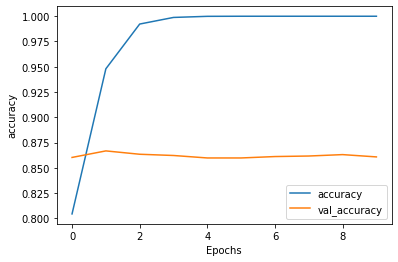

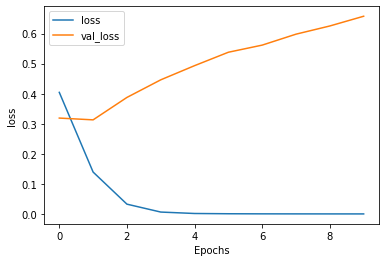

In [8]:
# Accuracy and Loss Plot
def plot_al(baseline, string):
    plt.plot(baseline.history[string])
    plt.plot(baseline.history['val_'+ string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

plot_al(baseline, "accuracy")
plot_al(baseline, 'loss')

The accuracy on the training set reach 1 at epoch 5 but the accuracy on the test set remain around 0.86. Another notable is the accuracy loss seems to increase over time. We can see that we are experiencing overfitting problem in the training set. Some tuning or regularization might be needed. Add Weight decay or increase the dropout value might be a good options. 

### 2. Bidirectional with 2-Layer LTSM & Convolutions

In [9]:
model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    Dropout(0.2),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 64)            6400064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 64)            20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 64)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 128)            66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [10]:
LTSM2 = model.fit(train_padded, train_labels, epochs = num_epochs, 
                    validation_data = (test_padded, test_labels), verbose =2)

Train on 22895 samples, validate on 5724 samples
Epoch 1/10
22895/22895 - 74s - loss: 0.4030 - accuracy: 0.8073 - val_loss: 0.3219 - val_accuracy: 0.8560
Epoch 2/10
22895/22895 - 70s - loss: 0.1521 - accuracy: 0.9433 - val_loss: 0.3531 - val_accuracy: 0.8618
Epoch 3/10
22895/22895 - 74s - loss: 0.0385 - accuracy: 0.9878 - val_loss: 0.6110 - val_accuracy: 0.8361
Epoch 4/10
22895/22895 - 72s - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.5717 - val_accuracy: 0.8482
Epoch 5/10
22895/22895 - 78s - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.6340 - val_accuracy: 0.8506
Epoch 6/10
22895/22895 - 73s - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.8608 - val_accuracy: 0.8424
Epoch 7/10
22895/22895 - 76s - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.8910 - val_accuracy: 0.8478
Epoch 8/10
22895/22895 - 70s - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.6608 - val_accuracy: 0.8470
Epoch 9/10
22895/22895 - 78s - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.9187 - val_accuracy: 0.8480
Epoch 

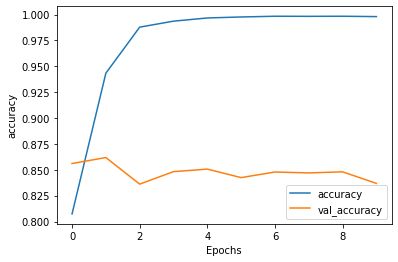

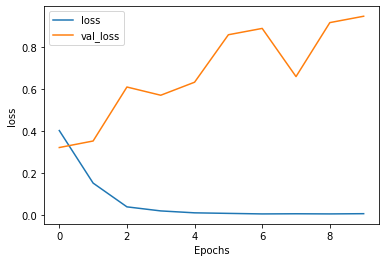

In [11]:
# Accuracy and Loss Plot
def plot_al(LTSM2, string):
    plt.plot(LTSM2.history[string])
    plt.plot(LTSM2.history['val_'+ string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

plot_al(LTSM2, "accuracy")
plot_al(LTSM2, 'loss')

The model still experience similar overfitting problems just like the baseline model. Method like Weight Decay or adjusting dropout value can be applied. 
However, the bidirectional RNN suprisingly does not seem to work as well compared to based line model. The accuracy on the test set only reach ~0.86 and consistently be around 0.84. The loss in the test set has a lot of up-and-down shape. Furthermore, it takes longer for the birectional RNN to run results.